# Loading in libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import colors 
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from IPython.display import display
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

# Functions

In [ ]:
#################### Initialize all functions ####################









def plotHisto(data, title, filename):
    # Creating histogram
    fig, axs = plt.subplots(1, 1, figsize=(10, 7), tight_layout=True)
    N, bins, patches = axs.hist(data, bins='auto', density=True)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        axs.spines[s].set_visible(False)

    # Remove x, y ticks
    axs.xaxis.set_ticks_position('none')
    axs.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    axs.xaxis.set_tick_params(pad=5)
    axs.yaxis.set_tick_params(pad=10)

    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(17)

    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(17)

    # Add x, y gridlines
    axs.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.6)

    # Setting color
    fracs = ((N**(1 / 5)) / N.max())
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

    # Adding extra features
    plt.xlabel("Parameter value", fontsize=20)
    plt.ylabel("Probability", fontsize=20)
    axs.yaxis.set_major_formatter(PercentFormatter(decimals=0))
    # legend = ['Distribution $a_1\ &\ a_3$']
    # plt.legend(legend)
    plt.title(title, fontsize=25)
    plt.savefig(filename)
    plt.show()


def plotWithError(all_data, datapoints, test):

    # Extract area
    max0_data = [all_data[:, t][:, 0].max() for t in range(len(all_data[0]))]
    min0_data = [all_data[:, t][:, 0].min() for t in range(len(all_data[0]))]
    max1_data = [all_data[:, t][:, 1].max() for t in range(len(all_data[0]))]
    min1_data = [all_data[:, t][:, 1].min() for t in range(len(all_data[0]))]
    max2_data = [all_data[:, t][:, 2].max() for t in range(len(all_data[0]))]
    min2_data = [all_data[:, t][:, 2].min() for t in range(len(all_data[0]))]

    # Set axes
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))

    # Plot data
    plotplot(axs, t, "tmp", datapoints, lights, True, "o")
    plotplot(axs, t, "tmp", test, lights, True, "d")

    # Get best of the bunch
    best_parameters = np.argmax(scores)

    # Plot best fit
    plotplot(axs, t, "Simulation data and gathered data",
             all_data[best_parameters], lights, False, "o")

    # Plot area
    plt.plot(t, max0_data, 'cornflowerblue', alpha=0.3)
    plt.plot(t, min0_data, 'cornflowerblue', alpha=0.3)
    plt.fill_between(t,
                     max0_data,
                     min0_data,
                     color='cornflowerblue',
                     alpha=0.1)
    plt.plot(t, max1_data, 'lightcoral', alpha=0.3)
    plt.plot(t, min1_data, 'lightcoral', alpha=0.3)
    plt.fill_between(t, max1_data, min1_data, color='lightcoral', alpha=0.1)
    plt.plot(t, max2_data, 'limegreen', alpha=0.3)
    plt.plot(t, min2_data, 'limegreen', alpha=0.3)
    plt.fill_between(t, max2_data, min2_data, color='limegreen', alpha=0.1)

    # Some prettyfication
    axs.set_ylim((0, 10))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig("simdata.png")
    plt.show()

    # Print score
    print(
        f"Score (MAD) (train - optim): {scoreFunc(datapoints, all_data[best_parameters])}"
    )
    print(
        f"Score (MAD) (test - optim): {scoreFunc(test, all_data[best_parameters])}"
    )
    print(
        f"Score (MAD) (true - optim): {scoreFunc(true_data, all_data[best_parameters])}"
    )
    print(
        f"Train - Test ratio: {(scoreFunc(datapoints, all_data[best_parameters]) / scoreFunc(test, all_data[best_parameters])) * 100}"
    )

# Run different farms

Creating a dataset for 4 farms that differ only in their light strength and the parameter values.

In [ ]:
def sigmoid(x, height=1, base=0, shift=0.5, slope=10):
    """Sigmoidal function that, using default values is bounded between [0,1] for both axes.

    Args:
        x (float): Input to function
        height (float, optional): Sets the maximum of the sigmoid. Defaults to 1.
        base (float, optional): Sets minimum of sigmoid. Defaults to 0.
        shift (float, optional): Sets halfway-point of sigmoid. Defaults to 0.5.
        slope (float, optional): Float parameter to set the slope. Defaults to 20.

    Returns:
        (float): Returns the Y value associated with inputs
    """
    return base + (height * (1 / (1 + np.exp((-x + shift) * slope))))


def scoreFunc(tdata, data):
    abs_diff = np.abs(tdata[:, 0] - data[:, 0])
    return abs_diff[~np.isnan(abs_diff)].mean()


# Defining model differential equations
def deriv1(y, t, days, l_on, l_off, steps, a, f, polarity):
    p, s, w = y

    light = calcLight(days, l_on, l_off, steps, t)

    dp = sum([
        # Influence of nutrients in the soil on potato growth
        (1. * s**1.5) * (1 * p),
        # Influence of light on potato growth
        +(1.5 * p) * light,
        # Competition with themselves
        -(0.85 * f[0](p)),
        # Potato loss due to worms
        -(2 * w) * (1. * p)
    ])
    ds = sum([
        # Soil nutrient consumption from potatoes
        (-1. * p**1.5) * (1 * s),
        # Worm contribution by feces to soil nutrients
        +(0.3 * w)
    ])
    dw = sum([
        # Toxic effect of too much nutrients on worm population
        (-2 * s) * (1 * w),
        # Migration caused by potatoes
        +(1.2 * p),
        # Worm birth
        +(0.1 * w),
        # Worm death
        -(a[0] * w)
    ])

    return dp, ds, dw


# Defining model differential equations
def deriv2(y, t, days, l_on, l_off, steps, a, f, polarity):
    p, s, w = y

    light = calcLight(days, l_on, l_off, steps, t)

    dp = sum([
        # Influence of nutrients in the soil on potato growth
        (1. * s**a[0]) * (1 * p),
        # Influence of light on potato growth
        +(1.5 * p) * light,
        # Competition with themselves
        -(a[1] * f[0](p)),
        # Potato loss due to worms
        -(2 * w) * (1. * p)
    ])
    ds = sum([
        # Soil nutrient consumption from potatoes
        (-1. * p**a[0]) * (1 * s),
        # Worm contribution by feces to soil nutrients
        +(0.3 * w)
    ])
    dw = sum([
        # Toxic effect of too much nutrients on worm population
        (-2 * s) * (1 * w),
        # Migration caused by potatoes
        +(1.2 * p),
        # Worm birth
        +(0.1 * w),
        # Worm death
        -(0.1 * w),
        polarity[0] * (0 * f[1](w) * light)
    ])

    return dp, ds, dw


def calcLight(days, l_on, l_off, steps, t):
    # Initialize steps
    l_steps = np.linspace(l_off, l_on, steps)
    t_steps = np.linspace(0, 1, steps + 1)
    light = 0

    # If light is 99 make the light go: off => on => off
    # Distribute light in stepwise fashion otherwise
    if steps != 99:
        for i in range(len(l_steps)):
            if days * t_steps[i] <= t <= days * t_steps[i + 1]:
                light = l_steps[i]
    else:
        if days * 0.25 <= t <= days * 0.75:
            light = l_on
        else:
            light = l_off
    return light


def simulation(simSettings, pturb, dfunc):
    # Unpack settings
    days, l_on, l_off, steps, y0, measurements, simP, simF, simPol = simSettings
    pTrue, pmean, pstd, prem = pturb

    # Set up time and lights
    t = np.linspace(1, days, days * measurements)
    lights = [calcLight(days, l_on, l_off, steps, i) for i in t]

    # Run simulation
    data = odeint(dfunc,
                  y0,
                  t,
                  args=(days, l_on, l_off, steps, simP, simF, simPol))

    # Perturb data to simulate missing values and error
    if pTrue: perturb(pmean, pstd, data, prem)

    return t, lights, data * 10


def perturb(pmean, pstd, data, prem):
    # Get perturbation vector
    perturb = np.random.normal(pmean, pstd, data.shape)

    # Perturb data
    data *= perturb

    # Choose certain ratio of the data by random to illustrate loss of data
    masks = np.random.choice([np.nan, 1],
                             size=(data.shape),
                             p=[prem, 1 - prem])

    # Throw away "lost" data
    data *= masks

    return data


def procData(data, title):
    # Create dataframe
    df = pd.DataFrame({
        "Potatoes": data[:, 0],
        "Nutrients": data[:, 1],
        "Worms": data[:, 2]
    })

    # Get descriptive statistics and drop unneeded info
    dfd = df.describe().drop(["25%", "50%", "75%", "count"])

    # Calculate percentage of missing values
    missings = df.isnull().sum() / 50 * 100

    # Append missing column to dataframe
    dfd = dfd.append(pd.DataFrame({"Missing (%)": missings}).T)

    # Fix labels for pretty printing later on
    dfd["Greenhouse"] = title[-1]
    dfd["Statistics"] = dfd.index
    return dfd


def plotplot(ax, t, title, data, lights, td, mtype, alpha=0.7):
    # Unpack data
    #     data *= 10
    P, S, W = data[:, 0], data[:, 1], data[:, 2]

    if td:
        if mtype == "d":
            # Plot
            ax.plot(t,
                    P,
                    mtype + 'b',
                    alpha=0.7,
                    markerfacecolor="None",
                    markeredgecolor='b',
                    markersize=10,
                    label='D2-Potatoes')
            ax.plot(t,
                    S,
                    mtype + 'r',
                    alpha=0.7,
                    markerfacecolor="None",
                    markeredgecolor='r',
                    markersize=10,
                    label='D2-Nutrients')
            ax.plot(t,
                    W,
                    mtype + 'g',
                    alpha=0.7,
                    markerfacecolor="None",
                    markeredgecolor='g',
                    markersize=10,
                    label='D2-Worms')
        elif mtype == "-":
            # Plot simulation data
            ax.plot(t,
                    P,
                    'cornflowerblue',
                    alpha=alpha,
                    lw=3,
                    label='S-potatoes')
            ax.plot(t, S, 'lightcoral', alpha=alpha, lw=3, label='S-Nutrients')
            ax.plot(t, W, 'limegreen', alpha=alpha, lw=3, label='S-Worms')
        else:
            ax.plot(t,
                    P,
                    mtype + 'b',
                    alpha=0.7,
                    markersize=8,
                    label='D1-Potatoes')
            ax.plot(t,
                    S,
                    mtype + 'r',
                    alpha=0.7,
                    markersize=8,
                    label='D1-Nutrients')
            ax.plot(t,
                    W,
                    mtype + 'g',
                    alpha=0.7,
                    markersize=8,
                    label='D1-Worms')
    else:
        # Plot simulation data
        plt.plot(t, P, 'cornflowerblue', alpha=alpha, lw=3, label='S-potatoes')
        plt.plot(t, S, 'lightcoral', alpha=alpha, lw=3, label='S-Nutrients')
        plt.plot(t, W, 'limegreen', alpha=alpha, lw=3, label='S-Worms')

    # Prettyfie that graph
    title = title + f" (Light strength={np.mean(lights)})"
    ax.set_xlabel('Time', fontsize=20)
    ax.set_ylabel('Count', fontsize=20)
    ax.set_title(title, fontsize=22)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(17)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(17)

    # Set axis ranges; by default this will put major ticks every 25.
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.set_xlim(0, max(t))
    tmp = np.dstack((P, S, W)).flatten()
    ax.set_ylim(0, max(tmp[~np.isnan(tmp)]) * 1.1)

    # Change major ticks to show every 10.
    ax.xaxis.set_major_locator(MultipleLocator(10))

    # Change minor ticks to show every 5. (10/2 = 5)
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))

    # Turn grid on for both major and minor ticks and style minor slightly
    # differently.
    ax.grid(which='major', color='#CCCCCC', linestyle='--', lw=2, alpha=0.9)
    ax.grid(which='minor', color='#CCCCCC', linestyle=':', lw=2, alpha=0.7)
    legend = ax.legend(prop={'size': 18})
    legend.get_frame().set_alpha(0.7)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 16})


def interestPlots(interest,
                  dfunc,
                  figsize_x=6,
                  figsize_y=4,
                  n_columns=2,
                  pturb=(False, 1, 0.2, 9. / 10, 10)):
    # Initialize grid plot
    n_figs = len(interest)
    fig, axes = plt.subplots(nrows=int(np.ceil(n_figs / n_columns)),
                             ncols=n_columns,
                             figsize=(figsize_x * n_columns, figsize_y *
                                      int(np.ceil(n_figs / n_columns))),
                             sharey=True,
                             sharex=False)
    descriptives = []
    datas = []
    all_lights = []

    # Iterate through all simulations of interest
    for wI in range(len(interest)):

        # Set up axes for figure
        if n_columns > 1:
            if np.ceil(n_figs / n_columns) < 2: axs = axes[wI % n_columns]
            else: axs = axes[int(np.floor(wI / n_columns)), wI % n_columns]
        else: axs = axes

        # Some mumbo jumbo for the plot titles
        if interest[wI][3] != 99: st = interest[wI][3]
        else: st = 'off/on/off'
        title = f"Greenhouse {wI+1}"

        # Run simulation
        t, lights, data = simulation(interest[wI], pturb, dfunc)

        # Get descriptives
        descriptives.append(procData(data, title))
        datas.append(data)
        all_lights.append(lights)

        # Get a single plot for the grid
        plotplot(axs, t, title, data, lights, True, "o")

    # Save and show grid plot
    plt.tight_layout()
    plt.savefig("4farmers.png")
    plt.show()

    return all_lights, descriptives, datas


def makeTable(lights, descriptives):
    # Make pretty table
    df = pd.melt(pd.concat(descriptives),
                 id_vars=['Greenhouse', 'Statistics'],
                 value_vars=['Potatoes', 'Nutrients', 'Worms'],
                 value_name='Values')
    lights = pd.DataFrame({
        "Greenhouse":
        np.linspace(1, 4, 4).astype(int).astype(str),
        "Statistics": ["" for _ in descriptives],
        "variable": ["Lights" for _ in descriptives],
        "Values":
        np.linspace(1.25, 2, len(descriptives))
    })
    df = pd.concat([lights, df], ignore_index=True)
    stats = df.set_index(['Greenhouse', 'variable',
                          'Statistics']).unstack('Greenhouse').round(2)
    display(stats)

    # Make less pretty table but with a lot less effort :)
    dscr = pd.concat(descriptives).set_index(["Greenhouse",
                                              "Statistics"]).round(2)
    display(dscr)

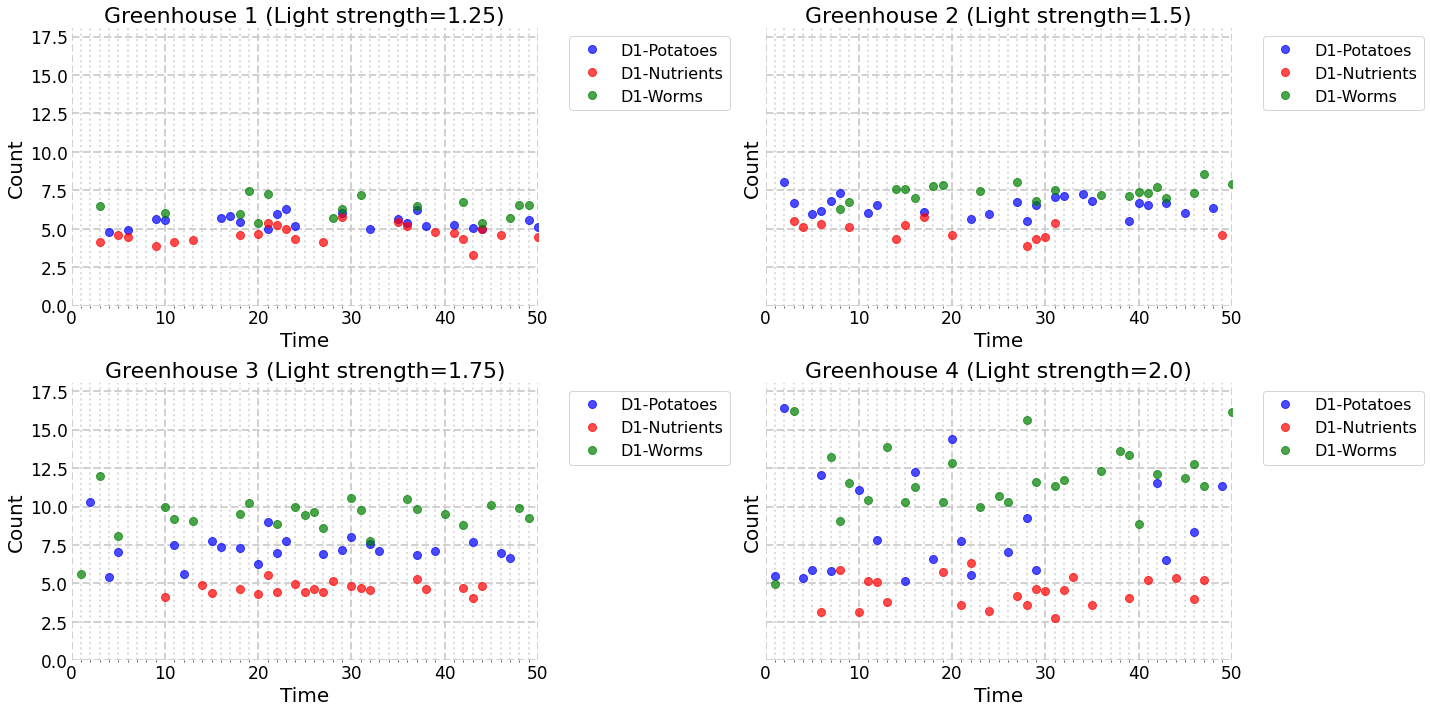

Values                     
Greenhouse                 1      2      3      4
variable  Statistics                             
Lights                  1.25   1.50   1.75   2.00
Nutrients Missing (%)  54.00  74.00  60.00  54.00
          max           5.78   5.77   5.55   6.30
          mean          4.64   4.90   4.67   4.44
          min           3.30   3.90   4.07   2.77
          std           0.56   0.56   0.37   1.00
Potatoes  Missing (%)  56.00  52.00  56.00  58.00
          max           6.27   8.03  10.28  16.39
          mean          5.44   6.50   7.29   8.64
          min           4.76   5.50   5.43   5.14
          std           0.44   0.61   1.01   3.30
Worms     Missing (%)  70.00  60.00  54.00  46.00
          max           7.47   8.55  11.99  16.22
          mean          6.35   7.41   9.40  11.76
          min           5.38   6.29   5.63   4.96
          std           0.65   0.51   1.20   2.36

Potatoes  Nutrients  Worms
Greenhouse Statistics                             
1          mean             5.44       4.64   6.35
           std              0.44       0.56   0.65
           min              4.76       3.30   5.38
           max              6.27       5.78   7.47
           Missing (%)     56.00      54.00  70.00
2          mean             6.50       4.90   7.41
           std              0.61       0.56   0.51
           min              5.50       3.90   6.29
           max              8.03       5.77   8.55
           Missing (%)     52.00      74.00  60.00
3          mean             7.29       4.67   9.40
           std              1.01       0.37   1.20
           min              5.43       4.07   5.63
           max             10.28       5.55  11.99
           Missing (%)     56.00      60.00  54.00
4          mean             8.64       4.44  11.76
           std              3.30       1.00   2.36
           min              5.14       2.77   4.96
           max             16.39       6.30  16.22
           Missing (%)     58.00      54.00  46.00

In [3]:
np.random.seed(89)
interest = [
    # days, lights on, lights off, steps, starting values => (p,s,w)
    # resolution of measurements (x*t), parameters, functions
    [50, 1.25, 1.25, 1, (0.5, 0.5, 0.5), 1, [0.115], [sigmoid], []],
    [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, [0.12], [sigmoid], []],
    [50, 1.75, 1.75, 1, (0.5, 0.5, 0.5), 1, [0.08], [sigmoid], []],
    [50, 2, 2, 1, (0.5, 0.5, 0.5), 1, [0.11], [sigmoid], []],
]

pturb = [True, 1, 0.1, 6. / 10]

lights, descriptives, datas = interestPlots(interest,
              deriv1,
              figsize_x=10,
              figsize_y=5,
              n_columns=2,
              pturb=pturb)

makeTable(lights, descriptives)

# Plot best fit

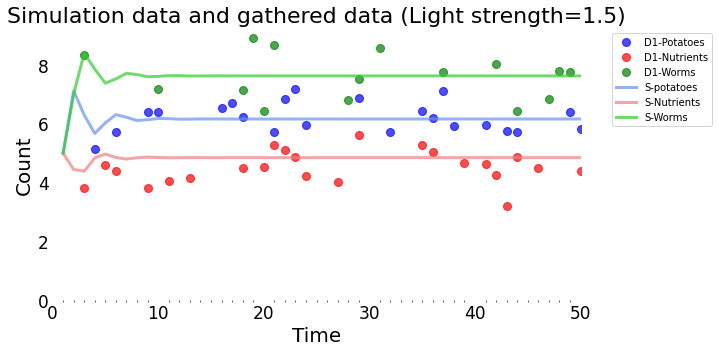

Score (MAD): 0.4165016665244291


In [4]:
# Set axes
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

# Set parameters
a = [1.5, 0.85]
fs = [sigmoid, sigmoid]
polarity = [1]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, a, fs, polarity]
pturb = [True, 1, 0.1, 6. / 10]

# Get data
np.random.seed(89)
t, lights, tdata = simulation(simSettings, pturb, deriv2)
plotplot(axs, t, "tmp", tdata, lights, True, "o")

# # start simulation
a = [1.55, 0.85]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, a, fs, polarity]
pturb = [False, 1, 0.1, 6. / 10]

t, lights, data = simulation(simSettings, pturb, deriv2)
plotplot(axs, t, "Simulation data and gathered data", data, lights, False, "o")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("simdata.png")
plt.show()

print(f"Score (MAD): {scoreFunc(tdata, data)}")

# Split data into train and test set

In [ ]:
def splitData(true_data, fraction_train):
    nonnans = np.argwhere(~np.isnan(true_data))
    index = np.arange(len(nonnans))
    np.random.shuffle(index)

    train = true_data.copy()
    test = true_data.copy()
    div = int(np.floor(len(index) * fraction_train))

    test_nan = index[:div]
    train_nan = index[div:]

    for i in train_nan:
        ti = nonnans[i]
        train[ti[0]][ti[1]] = np.nan
    for i in test_nan:
        ti = nonnans[i]
        test[ti[0]][ti[1]] = np.nan

    return train, test

In [5]:
a = [1.5, 0.85]
fs = [sigmoid, sigmoid]
polarity = [1]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, a, fs, polarity]
pturb = [True, 1, 0.1, 6. / 10]
dump_ratio = 3 / 9

# Get data
np.random.seed(89)
t, lights, true_data = simulation(simSettings, pturb, deriv2)

train, test = splitData(true_data, 2 / 3)

# Metropolis

In [ ]:
def metro_hast(tdata, simSettings, bestp, fs, polarity, pturb, N):

    # start simulation
    t, lights, data = simulation(simSettings, pturb, deriv2)
    scores = [scoreFunc(tdata, data)]
    all_data = [data]

    for i in tqdm(range(N)):
        # Perturb parameters slightly
        # newp = np.random.uniform(0.1,2,2)
        newp = np.random.normal(bestp[-1], 0.005, 2)
        simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, newp, fs, polarity]
        t, lights, data = simulation(simSettings, pturb, deriv2)
        news = scoreFunc(tdata, data)
        if news <= scores[-1]:
            scores.append(news)
            bestp.append(newp)
            all_data.append(data)
        else:
            random = np.random.rand()
            if random < scores[-1] / news:
                scores.append(news)
                bestp.append(newp)
                all_data.append(data)
    return scores, np.array(bestp), np.array(all_data)


In [6]:
# Set parameters
bestp = [np.array([1.5, 0.85])]
fs = [sigmoid, sigmoid]
polarity = [1]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, bestp[-1], fs, polarity]
pturb = [True, 1, 0.1, 6. / 10]

# Get data
np.random.seed(89)
t, lights, tdata = simulation(simSettings, pturb, deriv2)

# Run metropolis-hastings
pturb = [False, 1, 0.1, 6. / 10]

# Run metrop
scores, bestp, all_data = metro_hast(train, simSettings, bestp, fs, polarity,
                                     pturb, 1000)

print(len(train), len(test))

100%|██████████| 1000/1000 [00:48<00:00, 20.76it/s]

50 50


# Plot with error area and print cost function on best parameters

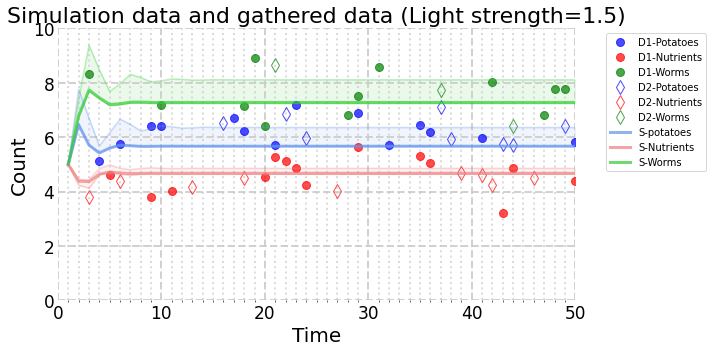

Score (MAD) (train - optim): 0.5659450872382756
Score (MAD) (test - optim): 0.614781036042836
Score (MAD) (true - optim): 0.5837036140762977
Train - Test ratio: 92.0563670735677


In [7]:
plotWithError(all_data, train, test)

# Make barchart

Variance: 0.0032465913022003507


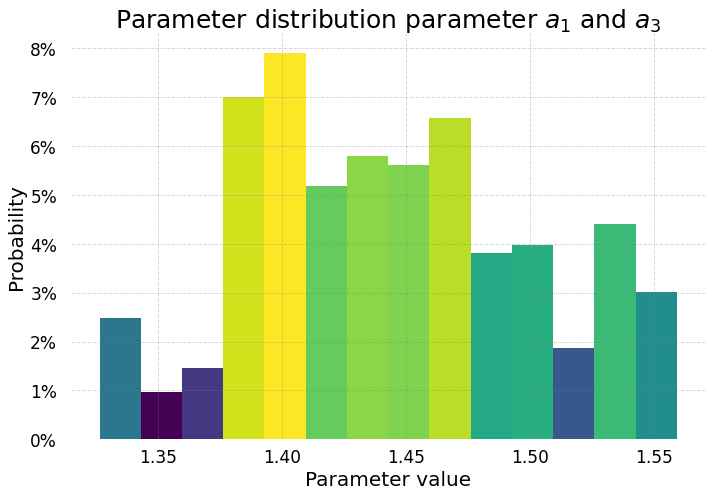

Variance: 0.0028666354056510793


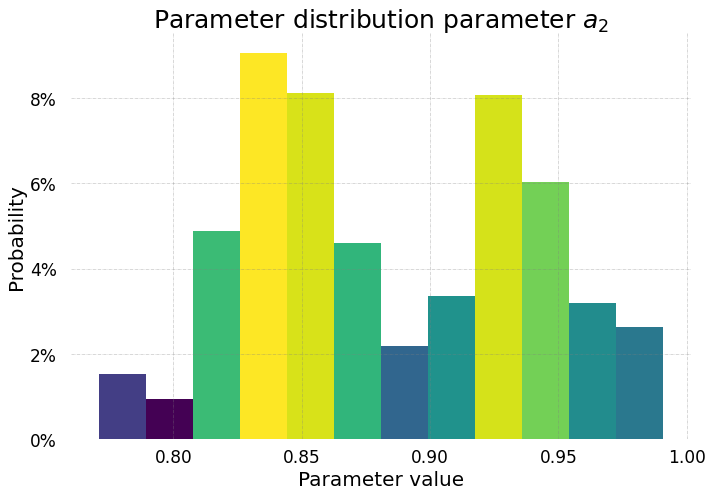

In [8]:
title = r'Parameter distribution parameter $a_1$ and $a_3$'
print(f"Variance: {np.var(bestp[:,0])}")
plotHisto(bestp[:, 0], title, "a1_3.png")
title = r'Parameter distribution parameter $a_2$'
print(f"Variance: {np.var(bestp[:,1])}")
plotHisto(bestp[:, 1], title, "a2.png")

# Pick MLE and compare train vs test dataset

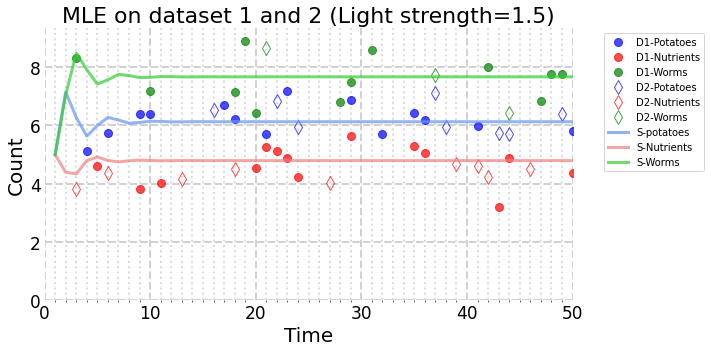

Train: 0.40508098378931073
Test: 0.443676466416957
Diff percentage: 0.9130098494082056


In [9]:
# Set parameters
bestp = [np.array([1.5, 0.85])]
fs = [sigmoid, sigmoid]
polarity = [1]
simSettings = [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, bestp[-1], fs, polarity]
pturb = [False, 1, 0.1, 6. / 10]

# Get data
np.random.seed(89)
t, lights, MLEdata = simulation(simSettings, pturb, deriv2)

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plotplot(axs, t, "tmp", train, lights, True, "o")
plotplot(axs, t, "tmp", test, lights, True, "d")
plotplot(axs, t, "MLE on dataset 1 and 2", MLEdata, lights, False, "")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("MLE_split_data.png")
plt.show()

trainScore = scoreFunc(train, MLEdata)
testScore = scoreFunc(test, MLEdata)

print(
    f"Train: {trainScore}\nTest: {testScore}\nDiff percentage: {trainScore/testScore}"
)

# Fit on lights

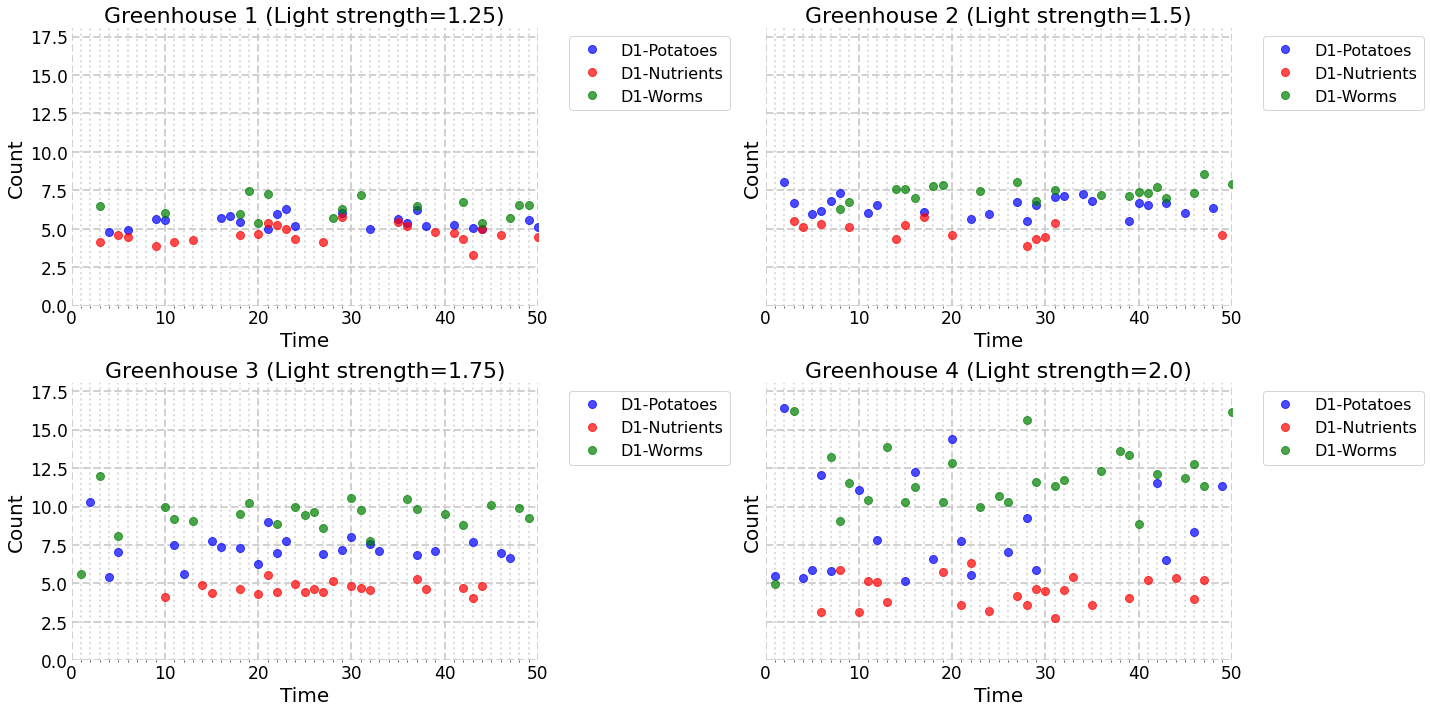

In [10]:
np.random.seed(89)
interest = [
    # days, lights on, lights off, steps, starting values => (p,s,w)
    # resolution of measurements (x*t), parameters, functions
    [50, 1.25, 1.25, 1, (0.5, 0.5, 0.5), 1, [0.115], [sigmoid], []],
    [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, [0.12], [sigmoid], []],
    [50, 1.75, 1.75, 1, (0.5, 0.5, 0.5), 1, [0.08], [sigmoid], []],
    [50, 2, 2, 1, (0.5, 0.5, 0.5), 1, [0.11], [sigmoid], []],
]

pturb = [True, 1, 0.1, 6. / 10]

lights, descriptives, datas_true = interestPlots(interest,
              deriv1,
              figsize_x=10,
              figsize_y=5,
              n_columns=2,
              pturb=pturb)

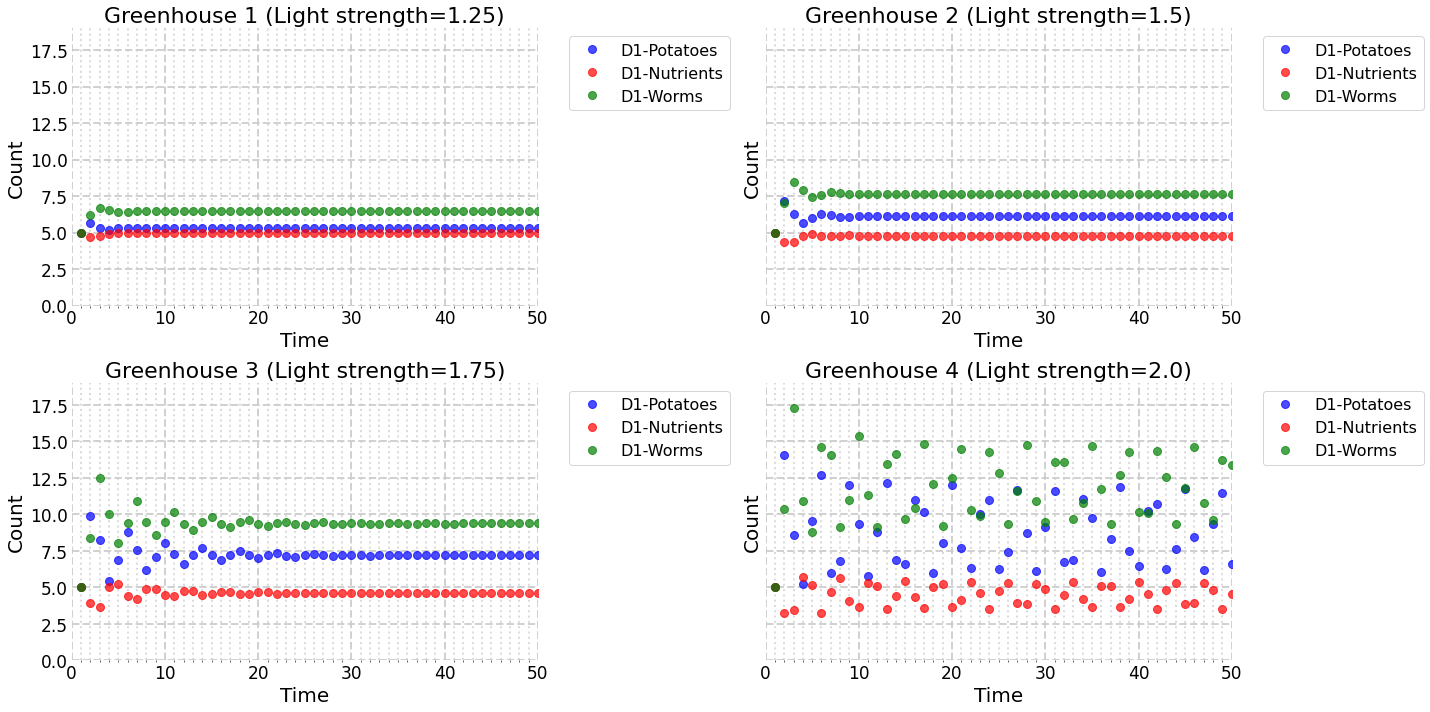

In [11]:
np.random.seed(89)
interest = [
    # days, lights on, lights off, steps, starting values => (p,s,w)
    # resolution of measurements (x*t), parameters, functions
    [50, 1.25, 1.25, 1, (0.5, 0.5, 0.5), 1, [1.5, 0.85], [sigmoid, sigmoid], [0]],
    [50, 1.5, 1.5, 1, (0.5, 0.5, 0.5), 1, [1.5, 0.85], [sigmoid, sigmoid], [0]],
    [50, 1.75, 1.75, 1, (0.5, 0.5, 0.5), 1, [1.5, 0.85], [sigmoid, sigmoid], [0]],
    [50, 2, 2, 1, (0.5, 0.5, 0.5), 1, [1.5, 0.85], [sigmoid, sigmoid], [0]],
]

pturb = [False, 1, 0.1, 6. / 10]

lights, descriptives, datas_sim = interestPlots(interest,
              deriv2,
              figsize_x=10,
              figsize_y=5,
              n_columns=2,
              pturb=pturb)

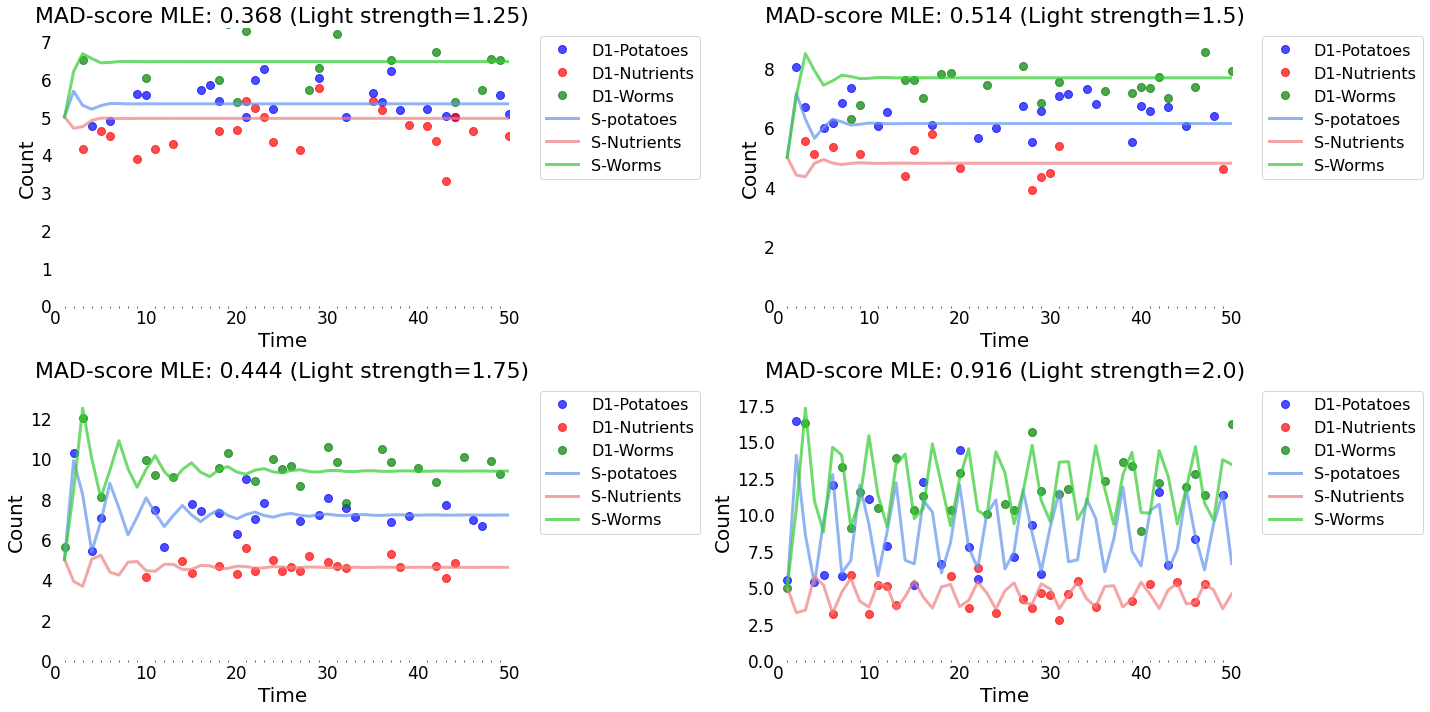

In [12]:
scores_lights = [str(round(scoreFunc(datas_true[i], datas_sim[i]),3)) for i in range(len(datas_sim))]

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
y = [0,1,0,1]
x = [0,0,1,1]
for i in range(len(datas_sim)):
    plotplot(axs[x[i]][y[i]], t, "MAD-score MLE: " + scores_lights[i], datas_true[i], lights[i], True, "o")
    plotplot(axs[x[i]][y[i]], t, "MAD-score MLE: " + scores_lights[i], datas_sim[i], lights[i], True, "-")
plt.tight_layout()
plt.savefig("light_fit.png")
plt.show()